# Temporal Convolutional Network (TCN)

Implemented as in *An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling (2018)* https://arxiv.org/abs/1803.01271

In [2]:
%config IPCompleter.greedy=True
%matplotlib inline

import sys
sys.path.append('..')

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from metrics import calc_tdi_tdm, squared_error, absolute_error
from utilities import plot_forecasts, Evaluation
from datasets import Traffic, UCR18, split_dataset
from models.tcn import TCN, train_model, get_forecasts

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ImportError: cannot import name 'train_model' from 'models.tcn' (..\models\tcn.py)

In [ ]:
# CONTROL PARAMS
TRAIN_MODEL = False

# Dataset: ECG5000

In [ ]:
train_loader.get_item()

In [ ]:
input_size = 84
output_size = 56

channel_sizes = [128] * 3
kernel_size = 5
dropout = 0.25
lr = 0.001
batch_size = 16
epochs = 30

# Load data
train = ECG5000("../data/ECG5000/ECG5000_TRAIN.tsv", input_size, output_size)
test = ECG5000("../data/ECG5000/ECG5000_TEST.tsv", input_size, output_size)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)

# Train and save model OR load model from pickle
if TRAIN_MODEL:
    
    model = TCN(input_size, output_size, channel_sizes, kernel_size=kernel_size, dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()
    
    train_model(model, optimizer, loss_fn, train_loader, epochs=epochs)
    
    with open('./saved_models/tcn_ecg.pickle', 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./saved_models/tcn_ecg.pickle', 'rb') as handle:
        model = pickle.load(handle)

        
# Get forecasts on test
x_test, y_test, yhat_test = get_forecasts(model, test_loader)

# Plots
plot_forecasts(x_test, y_test, yhat_test, n=3, shuffle=True)

# Compute evaluation
res_ecg = Evaluation(y_test, yhat_test, "ECG5000", "TCN")

### Evaluation

Evaluation of method 'TCN' on dataset 'ECG5000', a total of 4496 56-step forecasts.



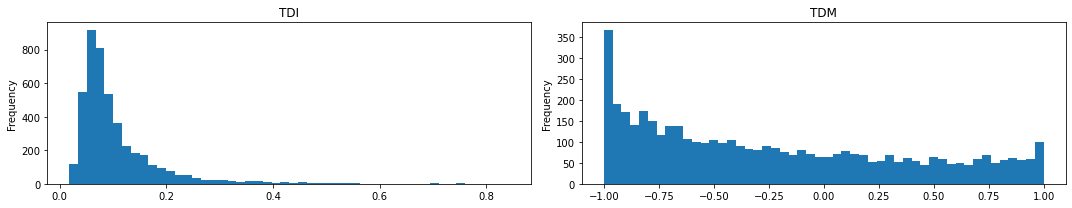

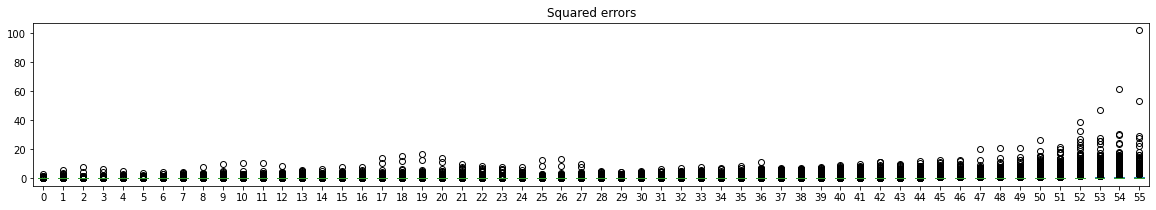

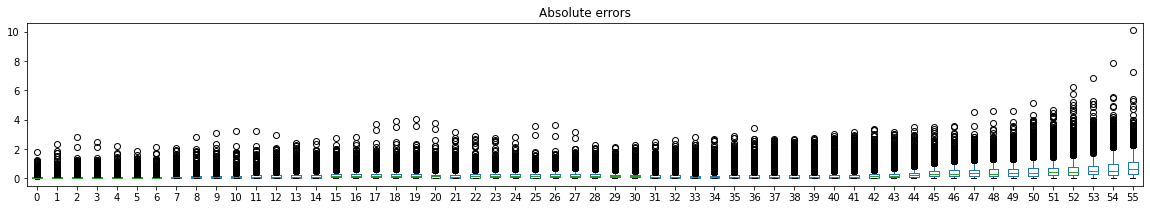

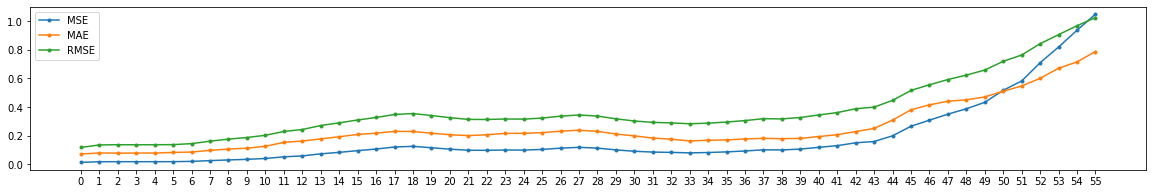

In [5]:
print(res_ecg)
res_ecg.plot()

# Dataset: Traffic

Training model: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [14:58<00:00, 29.95s/epoch, train_loss=8.76e-5]


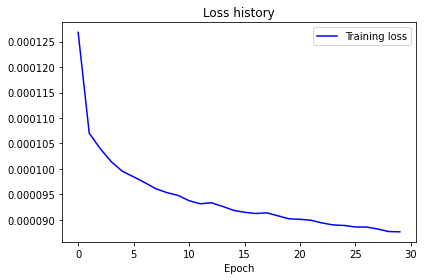

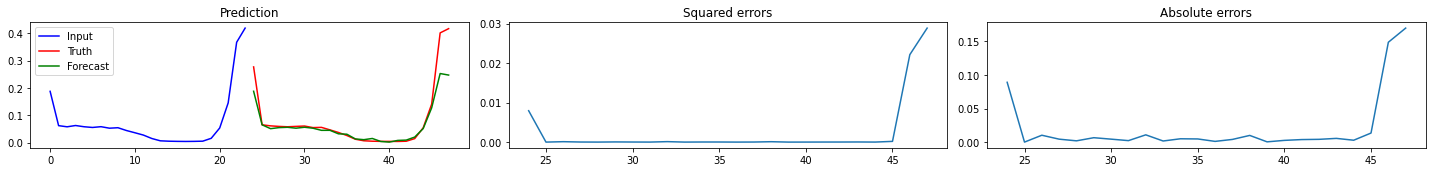

TDI: 0.06, TDM: -0.52 


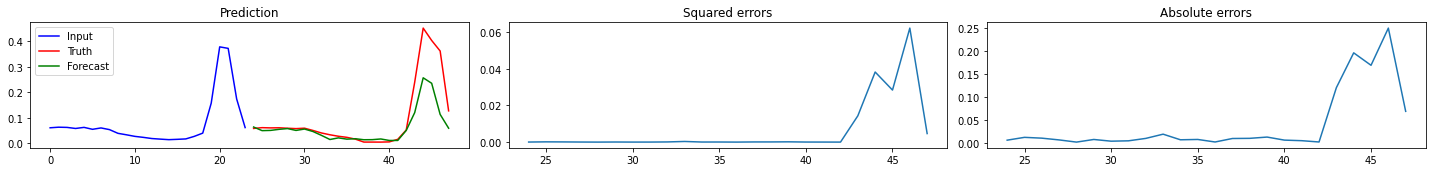

TDI: 0.12, TDM: -0.47 


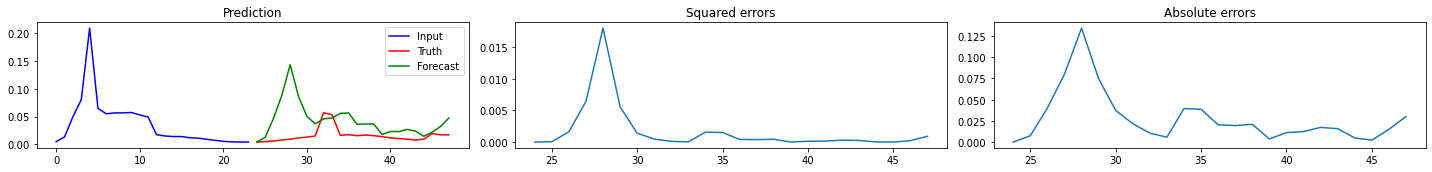

TDI: 0.28, TDM: 0.25 


In [6]:
input_size = 24
output_size = 24

channel_sizes = [128] * 3
kernel_size = 5
dropout = 0.25
lr = 0.001
batch_size = 16
epochs = 30
 
# Load data
ds = Traffic("../data/mvdata/traffic.txt", 24, 24, usecol=0)
train, test = split_dataset(ds, 0.2)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)

# Train and save model OR load model from pickle
if TRAIN_MODEL:
    
    model = TCN(input_size, output_size, channel_sizes, kernel_size=kernel_size, dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()
    
    train_model(model, optimizer, loss_fn, train_loader, epochs=epochs)
    
    with open('./saved_models/tcn_traffic.pickle', 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./saved_models/tcn_traffic.pickle', 'rb') as handle:
        model = pickle.load(handle)

        
# Get forecasts on test
x_test, y_test, yhat_test = get_forecasts(model, test_loader)

# Plots
plot_forecasts(x_test, y_test, yhat_test, n=3, shuffle=True)

# Compute evaluation
res_traffic = Evaluation(y_test, yhat_test, "Traffic", "TCN")

### Evaluation

Evaluation of method 'TCN' on dataset 'Traffic', a total of 3488 24-step forecasts.



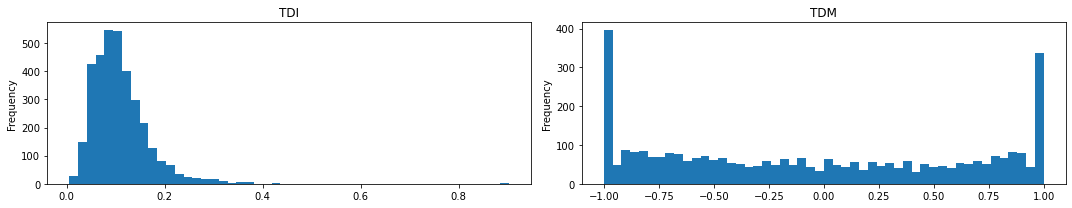

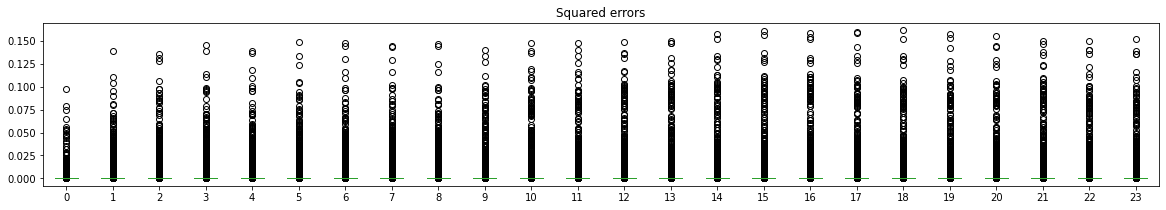

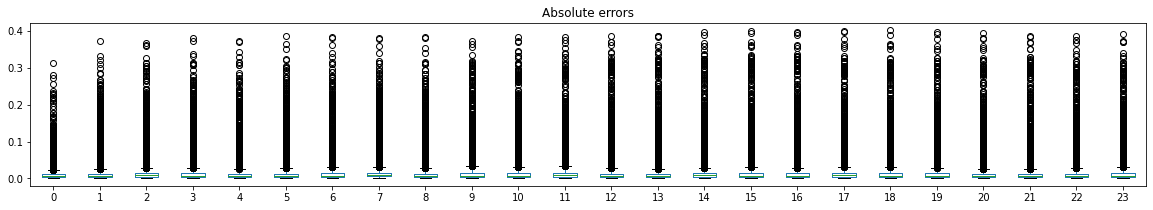

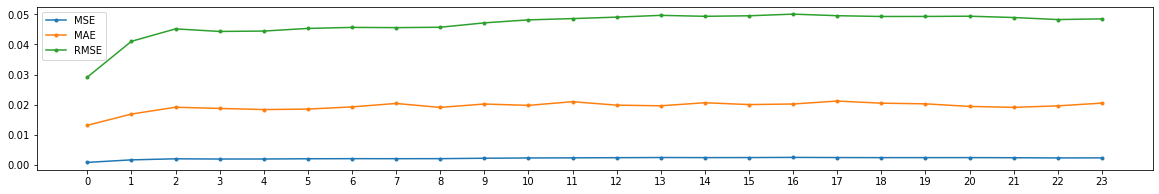

In [7]:
print(res_traffic)
res_traffic.plot()